<a href="https://colab.research.google.com/github/duraichellam001-tech/ev-range-model/blob/main/notebooks/04_baseline_ML_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ev-range-model/data/training_dataset.csv')
print(dataset.shape)
dataset.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(15, 13)


,speed_factor,avg_speed,max_speed,std_speed,percent_idle,avg_accel,avg_decel,accel_std,peak_accel,cycle_duration,total_distance_km,energy_Wh,wh_per_km
0,0.6,18.753492,54.432,14.119993,0.204661,0.300980,0.344702,0.372577,0.880000,1373,7.152373,731.422162,102.262861
1,0.8,25.004655,72.576,18.826658,0.197378,0.401307,0.459602,0.496770,1.173333,1373,9.536498,1187.205757,124.490750
2,1.0,31.255819,90.720,23.533322,0.196650,0.501634,0.574503,0.620962,1.466667,1373,11.920622,1772.295684,148.674763
3,1.2,37.506983,108.864,28.239987,0.195921,0.601961,0.689404,0.745155,1.760000,1373,14.304747,2497.618506,174.600681
4,1.5,46.883729,136.080,35.299984,0.193736,0.752451,0.861754,0.931443,2.200000,1373,17.880933,3876.045783,216.769769


In [3]:
X = dataset.drop(columns=['wh_per_km', 'energy_Wh'])
y = dataset['wh_per_km']


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

models = {
    'Linear': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=200)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name:12s} → MAE: {mae:.2f}, R²: {r2:.3f}")


Linear       → MAE: 8.18, R²: 0.984
RandomForest → MAE: 23.96, R²: 0.817
XGBoost      → MAE: 33.02, R²: 0.592


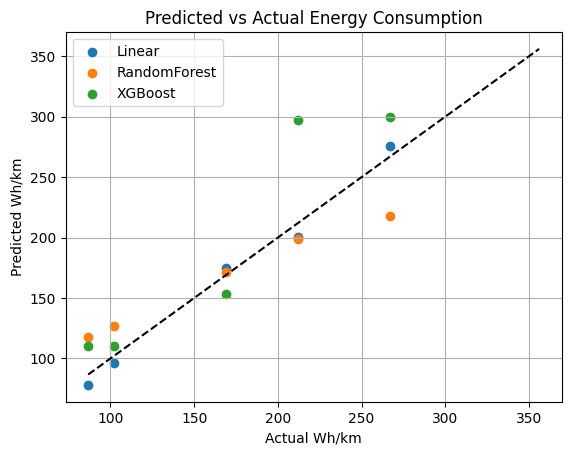

In [7]:
import matplotlib.pyplot as plt

for name, model in models.items():
    preds = model.predict(X_test)
    plt.scatter(y_test, preds, label=name)

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')  # 45° line
plt.xlabel('Actual Wh/km')
plt.ylabel('Predicted Wh/km')
plt.legend()
plt.title('Predicted vs Actual Energy Consumption')
plt.grid(True)
plt.show()


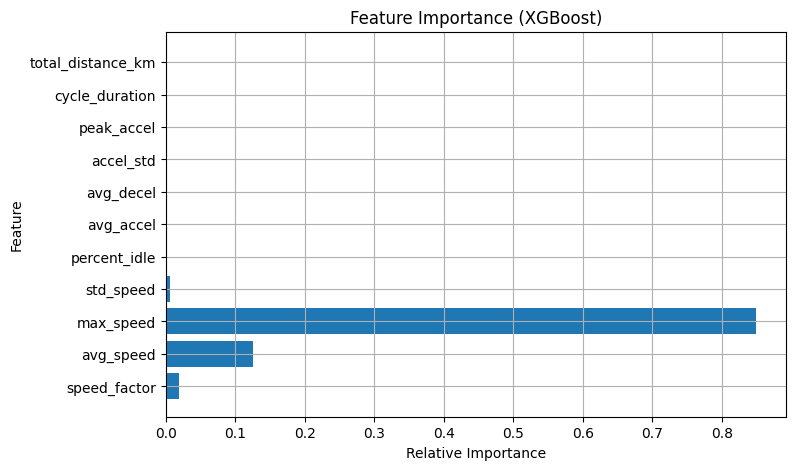

In [8]:
model = models['XGBoost']   # or RandomForest

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


In [11]:
for feat, imp in sorted(zip(features, importances), key=lambda x: x[1], reverse=True):
    print(f"{feat:20s} → {imp:.3f}")


max_speed            → 0.849
avg_speed            → 0.125
speed_factor         → 0.019
std_speed            → 0.006
total_distance_km    → 0.000
avg_accel            → 0.000
percent_idle         → 0.000
avg_decel            → 0.000
accel_std            → 0.000
peak_accel           → 0.000
cycle_duration       → 0.000


### Observation
The feature-importance plot shows `max_speed` as the dominant predictor of Wh/km,
with `avg_speed` contributing marginally. Other features have near-zero importance
due to strong correlation and low variance in this dataset.

### Interpretation
This matches physical intuition—energy consumption in EVs is strongly driven
by aerodynamic load, which grows with velocity squared. Additional parameters
(mass, drag coefficient, rolling resistance) will be introduced in the next
phase to decouple these effects and enrich model learning.


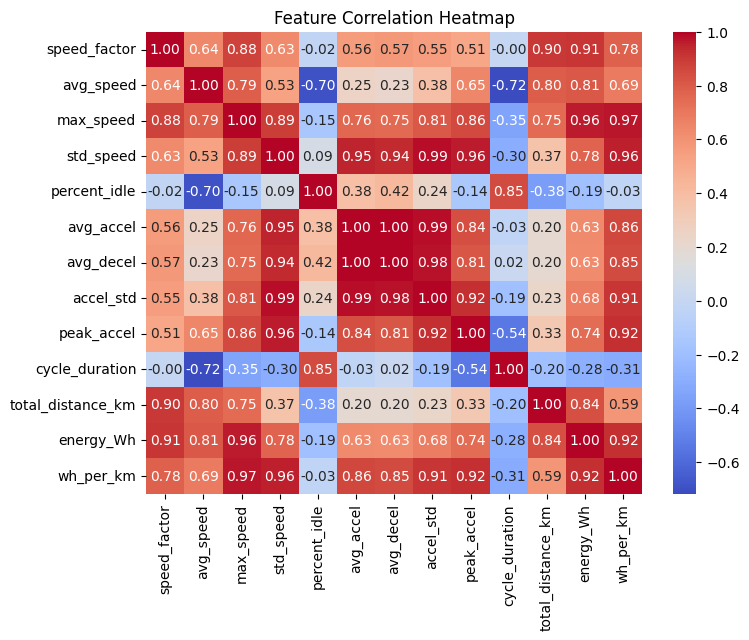

In [10]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()
